# Homogén adatok átalakítása modell tanításhoz

In [1]:
import pandas as pd
import numpy as np
from config import data_root
import random
import calendar
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler

Random napok generálása a tanuló napok és validációs napok kiválasztására

In [2]:


import random
from datetime import datetime, timedelta
random.seed(42)
def random_dates(years,validation_day_no, size_reducing_day_no):
    all_random_dates=validation_day_no+size_reducing_day_no
    dates = []
    size_reducing_dates=[]
    for year in years:  
        for month in range(1, 13):
            for i in range(all_random_dates):
                # Generate a random day in the current month
                day = random.randint(1, 28)  # To avoid issues with different month lengths
                date = datetime(year, month, day).date()
                if i>=validation_day_no:
                    size_reducing_dates.append(date)
                else:
                    dates.append(date)
    return dates,size_reducing_dates

# Example usage
years = [2022,2023]
random_days,days_to_keep = random_dates(years,3,10)
for date in random_days:
    print(date)

2022-01-21
2022-01-04
2022-01-01
2022-02-03
2022-02-19
2022-02-14
2022-03-23
2022-03-21
2022-03-23
2022-04-26
2022-04-06
2022-04-23
2022-05-04
2022-05-12
2022-05-28
2022-06-03
2022-06-18
2022-06-10
2022-07-22
2022-07-08
2022-07-25
2022-08-27
2022-08-12
2022-08-06
2022-09-21
2022-09-06
2022-09-18
2022-10-22
2022-10-11
2022-10-27
2022-11-03
2022-11-07
2022-11-19
2022-12-05
2022-12-08
2022-12-24
2023-01-05
2023-01-17
2023-01-16
2023-02-14
2023-02-20
2023-02-03
2023-03-24
2023-03-04
2023-03-22
2023-04-15
2023-04-01
2023-04-24
2023-05-27
2023-05-21
2023-05-17
2023-06-20
2023-06-11
2023-06-16
2023-07-03
2023-07-03
2023-07-24
2023-08-18
2023-08-06
2023-08-09
2023-09-23
2023-09-10
2023-09-13
2023-10-11
2023-10-01
2023-10-19
2023-11-03
2023-11-02
2023-11-28
2023-12-24
2023-12-19
2023-12-19


In [3]:

raw_data=pd.read_pickle(data_root+'data.pkl')


In [6]:
raw_data.shape

(4027684, 42)

In [4]:
raw_data.head()

,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY_SORSZAM,IDO,TENY_IDO,OSSZ_KESES (m),TERV_IDOTARTAM (m),KESES (m),TENY_IDOTARTAM (m),RELATIV_KESES,...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
0,2010,2022-01-01,1,2022-01-01 00:25:00,2022-01-01 00:25:24,0.400000,0.0,0.400000,0.400000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,2010,2022-01-01,2,2022-01-01 00:29:00,2022-01-01 00:30:10,1.166667,4.0,0.766667,4.766667,0.087452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,2010,2022-01-01,3,2022-01-01 00:30:00,2022-01-01 00:30:40,0.666667,1.0,-0.500000,0.500000,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,2010,2022-01-01,4,2022-01-01 00:35:00,2022-01-01 00:34:55,-0.083333,5.0,-0.750000,4.250000,-0.081081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,2010,2022-01-01,5,2022-01-01 00:36:00,2022-01-01 00:36:09,0.150000,1.0,0.233333,1.233333,0.104478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [7]:
#ezek csak a kezdo megálló nevei a met infóhoz..
raw_data.drop(columns=['SZH_NEV','POLGARI_NEV','stop_name'],inplace=True)

In [8]:
zero_time_rows=raw_data[raw_data['TERV_IDOTARTAM (m)']+raw_data['KESES (m)']==0.0]

In [13]:
zero_time_rows.tail()
# ha ezek opcionális megállók, áthaladások - 0 terv 0 tény ki lesz véve - 
# 0 terv, nem 0 tény - megálltunk - kisebb mint 3 perc mondjuk azt mondjuk hogy nem hiba. 



,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY_SORSZAM,IDO,TENY_IDO,OSSZ_KESES (m),TERV_IDOTARTAM (m),KESES (m),TENY_IDOTARTAM (m),RELATIV_KESES,...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
107814,37455,2023-12-31,0,2023-12-31 13:12:00,2023-12-31 13:12:00,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.266667,1.0,False
107834,37463,2023-12-31,0,2023-12-31 15:12:00,2023-12-31 15:12:00,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.450000,1.0,False
107869,37463,2023-12-31,34,2023-12-31 17:24:00,2023-12-31 17:26:06,2.100000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
107871,37463,2023-12-31,35,2023-12-31 17:25:00,2023-12-31 17:26:26,1.433333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,False
107874,37467,2023-12-31,0,2023-12-31 07:12:00,2023-12-31 07:12:00,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,1.0,False


In [9]:
zero_time_rows.shape

(545980, 39)

In [10]:
raw_data.isnull().values.any() 

False

In [11]:
raw_data.isin([np.inf, -np.inf]).any() 


VONATSZAM                                  False
KOZLEKEDESI_NAP                            False
ESEMENY_SORSZAM                            False
IDO                                        False
TENY_IDO                                   False
OSSZ_KESES (m)                             False
TERV_IDOTARTAM (m)                         False
KESES (m)                                  False
TENY_IDOTARTAM (m)                         False
RELATIV_KESES                              False
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)           False
ELOZO_SZAKASZ_KESES (m)                    False
ELOZO_SZAKASZ_RELATIV_KESES                False
ID                                         False
CSATL_MAX_KESES (m)                        False
MENETREND_IDO (m)                          False
tx                                         False
t                                          False
tn                                         False
r                                          False
LINE                

In [14]:
np.isinf(raw_data[['RELATIV_KESES','ELOZO_SZAKASZ_RELATIV_KESES','ELOZO_VONAT_RELATIV_KESES']]).values.sum()

0

# Validáció adat full verziója

In [16]:
#raw_data['KOZLEKEDESI_NAP']=pd.to_datetime(raw_data['ELOZO_ESEMENY_IDO']).dt.date
df_to_validate_orig = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]




C:\Users\ELTE\AppData\Local\Temp\ipykernel_7516\2797493571.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_to_validate_orig = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]


In [17]:
df_to_validate_orig.to_pickle(data_root+'validation_orig.pkl')
del df_to_validate_orig

In [17]:
# nem kellene már...
import datetime
def convert_time_to_minute(input):
    if isinstance(input,datetime.time):
        return float(input.hour*60+input.minute)
    #TODO does totalseconds return some decent value for negativ timedelta? 
    # ANS: it is good
    if isinstance(input,datetime.timedelta):
        ret = input.total_seconds()/60
       # if datetime.timedelta(0)>input:
       #     return -ret
        return ret
    if isinstance(input,float):
        return input
    return -1.0

In [18]:
# átalakítjuk időt percekké

In [18]:
raw_data.head()

,VONATSZAM,KOZLEKEDESI_NAP,ESEMENY_SORSZAM,IDO,TENY_IDO,OSSZ_KESES (m),TERV_IDOTARTAM (m),KESES (m),TENY_IDOTARTAM (m),RELATIV_KESES,...,ÁI,ÁE,Kezdés,Befejezés,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
0,2010,2022-01-01,1,2022-01-01 00:25:00,2022-01-01 00:25:24,0.400000,0.0,0.400000,0.400000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,2010,2022-01-01,2,2022-01-01 00:29:00,2022-01-01 00:30:10,1.166667,4.0,0.766667,4.766667,0.087452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,2010,2022-01-01,3,2022-01-01 00:30:00,2022-01-01 00:30:40,0.666667,1.0,-0.500000,0.500000,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,2010,2022-01-01,4,2022-01-01 00:35:00,2022-01-01 00:34:55,-0.083333,5.0,-0.750000,4.250000,-0.081081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
4,2010,2022-01-01,5,2022-01-01 00:36:00,2022-01-01 00:36:09,0.150000,1.0,0.233333,1.233333,0.104478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [19]:
#atzt tartjuk meg, ami kell a traininghez és predikcióhoz
def prepare_for_ml_models(raw_data):
    to_drop=['VONATSZAM','IDO',"TENY_IDO","ESEMENY_SORSZAM","RELATIV_KESES","ID","OSSZ_KESES (m)",'TENY_IDOTARTAM (m)',"Kezdés","Befejezés",]
    #raw_data[['MENETREND_IDO','ELOZO_KESES','ELOZO VONAT KESES','KESES']] = raw_data[['MENETREND_IDO','ELOZO_KESES','ELOZO VONAT KESES','KESES']].map(convert_time_to_minute)
    raw_data.drop(to_drop,axis=1,inplace=True)   
    raw_data['VONAL_STATUSZ_VALTOZOTT']=raw_data['VONAL_STATUSZ_VALTOZOTT'].astype(float)
    raw_data.fillna(0.0,inplace=True)
    
prepare_for_ml_models(raw_data)

In [20]:
#TODO boolean vs categorical?
#TODO Vonal, Line mit kellene kezdeni velük? kicsit kölséges használni őket..
#raw_data[['VONATSZAM','VONAL','VONTATO_TIPUS','Lassúmenet típusa','Kizárás (1=VZ,2=LJ)','Kiutalt menetvonalak zavartatása nélkül','Státus','Fels.vez. kikapcsolása']]=raw_data[['VONATSZAM','VONAL','VONTATO_TIPUS','Lassúmenet típusa','Kizárás (1=VZ,2=LJ)','Kiutalt menetvonalak zavartatása nélkül','Státus','Fels.vez. kikapcsolása']].astype("category")

# sklearn nem bír  category-kal
#raw_data.drop(columns=['VONATSZAM','VONAL','VONTATO_TIPUS'],inplace=True)

# vonatszám kell majd spearman-hez
#raw_data.drop(columns=['VONAL','VONTATO_TIPUS'],inplace=True)


In [20]:

raw_data.dtypes


KOZLEKEDESI_NAP                            datetime64[ns]
TERV_IDOTARTAM (m)                                float64
KESES (m)                                         float64
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)                  float64
ELOZO_SZAKASZ_KESES (m)                           float64
ELOZO_SZAKASZ_RELATIV_KESES                       float64
CSATL_MAX_KESES (m)                               float64
MENETREND_IDO (m)                                   int64
tx                                                float64
t                                                 float64
tn                                                float64
r                                                 float64
LINE                                                int64
Érintett objektum típusa                          float64
Lassúmenet típusa                                 float64
Lassúmenet hossza                                 float64
Lassúmenet mértéke (km/h)                         float64
Lassúmenet mér

In [21]:
raw_data.tail()

,KOZLEKEDESI_NAP,TERV_IDOTARTAM (m),KESES (m),ELOZO_SZAKASZ_TERV_IDOTARTAM (m),ELOZO_SZAKASZ_KESES (m),ELOZO_SZAKASZ_RELATIV_KESES,CSATL_MAX_KESES (m),MENETREND_IDO (m),tx,t,...,I,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
107889,2023-12-31,0.0,0.200000,5.0,0.250000,0.024390,0.0,489,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000,1.000000,0.0
107890,2023-12-31,5.0,-0.466667,0.0,0.200000,1.000000,0.0,494,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.766667,-0.083032,0.0
107891,2023-12-31,0.0,0.300000,5.0,-0.466667,-0.048951,0.0,494,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383333,1.000000,0.0
107892,2023-12-31,11.0,0.166667,0.0,0.300000,1.000000,0.0,505,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.816667,0.035793,0.0
107893,2023-12-31,0.0,-0.733333,11.0,0.166667,0.007519,0.0,505,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.383333,0.089924,0.0


In [22]:
df_to_validate = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]
#NEM HASZNÁLJUK AZ EGÉSZ ADATOT
df_remaining = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(days_to_keep)]
del raw_data

C:\Users\ELTE\AppData\Local\Temp\ipykernel_7516\3482023882.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_to_validate = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(random_days)]
C:\Users\ELTE\AppData\Local\Temp\ipykernel_7516\3482023882.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_remaining = raw_data[raw_data['KOZLEKEDESI_NAP'].isin(days_to_keep)]


In [23]:
#ez is kell spearmann-hez
df_to_validate.drop(columns=['KOZLEKEDESI_NAP'],inplace=True)
df_remaining.drop(columns=['KOZLEKEDESI_NAP'],inplace=True)


In [24]:
#df_to_validate.drop(columns=['ID'],inplace=True)
#df_remaining.drop(columns=['ID'],inplace=True)
#raw_data.to_csv(data_root+'preprocessed_data.csv', index=False)
df_to_validate.to_csv(data_root+'validation_data.csv', index=False)
df_remaining.to_csv(data_root+'train_test_data.csv', index=False)



In [25]:
del df_to_validate
del df_remaining

# Modellek tanítása

A modellek tanításához elég innentől futtatni.

In [1]:
import pandas as pd
data_root = "data/"

raw_data=pd.read_csv(data_root+'train_test_data.csv')
#raw_data['VONAL STATUSZ VALTOZOTT']=raw_data['VONAL STATUSZ VALTOZOTT'].head().astype(float)



In [2]:

raw_data.columns


Index(['TERV_IDOTARTAM (m)', 'KESES (m)', 'ELOZO_SZAKASZ_TERV_IDOTARTAM (m)',
       'ELOZO_SZAKASZ_KESES (m)', 'ELOZO_SZAKASZ_RELATIV_KESES',
       'CSATL_MAX_KESES (m)', 'MENETREND_IDO (m)', 'tx', 't', 'tn', 'r',
       'LINE', 'Érintett objektum típusa', 'Lassúmenet típusa',
       'Lassúmenet hossza', 'Lassúmenet mértéke (km/h)',
       'Lassúmenet mértéke motorvonatra (km/h)', 'Fels.vez. kikapcsolása', 'I',
       'E', 'ÁI', 'ÁE', 'Kizárás (1=VZ,2=LJ)',
       'Kiutalt menetvonalak zavartatása nélkül', 'Státus',
       'ELOZO_VONAT_KESES (m)', 'ELOZO_VONAT_RELATIV_KESES',
       'VONAL_STATUSZ_VALTOZOTT'],
      dtype='object')

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
def split_train_test(data, normalize=False):
    raw_data=data.copy()
    X_scaler=None
    y_scaler=None
    pd_y= raw_data[['KESES (m)']]
    pd_X = raw_data.drop(columns=['KESES (m)'])
    if 'RELATIV_KESES' in raw_data.columns:
        pd_X.drop(columns=['RELATIV_KESES'],inplace=True)
    if normalize:
        X_scaler = MinMaxScaler()
        pd_X[pd_X.columns] = X_scaler.fit_transform(pd_X[pd_X.columns])
        y_scaler=MinMaxScaler()
        pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])
   
    '''
    if normalize:
        scaler = MinMaxScaler()
        pd_X[pd_X.columns] = scaler.fit_transform(pd_X[pd_X.columns])
    '''
    X_train, X_test, y_train, y_test = train_test_split(pd_X, pd_y, test_size=0.3, random_state=44)
    return X_train, X_test, y_train, y_test,X_scaler,y_scaler

In [4]:
X_train, X_test, y_train, y_test,_,_ = split_train_test(raw_data)
#X_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
#X_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)

''''
TrTD= X_train[['VONATSZAM','KOZLEKEDESI_NAP']]
X_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
TeTD= X_test[['VONATSZAM','KOZLEKEDESI_NAP']]
X_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
'''

"'\nTrTD= X_train[['VONATSZAM','KOZLEKEDESI_NAP']]\nX_train.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)\nTeTD= X_test[['VONATSZAM','KOZLEKEDESI_NAP']]\nX_test.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)\n"

In [5]:
X_train.head()

,TERV_IDOTARTAM (m),ELOZO_SZAKASZ_TERV_IDOTARTAM (m),ELOZO_SZAKASZ_KESES (m),ELOZO_SZAKASZ_RELATIV_KESES,CSATL_MAX_KESES (m),MENETREND_IDO (m),tx,t,tn,r,...,I,E,ÁI,ÁE,"Kizárás (1=VZ,2=LJ)",Kiutalt menetvonalak zavartatása nélkül,Státus,ELOZO_VONAT_KESES (m),ELOZO_VONAT_RELATIV_KESES,VONAL_STATUSZ_VALTOZOTT
478472,0.0,1.0,0.616667,0.235669,16.316667,959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
334870,2.0,1.0,-0.416667,-0.263158,0.000000,872,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000,0.069767,0.0
803000,1.0,2.0,0.200000,0.047619,0.000000,1366,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.783333,0.654179,0.0
942254,0.0,2.0,0.366667,0.083969,0.000000,1202,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.766667,1.000000,0.0
624557,3.0,1.0,-0.283333,-0.165049,0.000000,455,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316667,0.050132,0.0


# DecisionTreeRegressor

In [15]:
import numpy as np

In [7]:
max_depth=[]

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/
def train_DRT(X_train, X_test, y_train):
    
    # Define the parameter grid to tune the hyperparameters
    param_grid = {
        'max_depth': [10, 20, 30, None],
    }
    dtree_reg = DecisionTreeRegressor(random_state=42) # Initialize a decision tree regressor
    grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=3, n_jobs=-1,verbose=2,scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(best_params)
    predictions = model.predict(X_test)
    return model, predictions
'''
def train_DRTF(X_train, X_test, y_train):
    
        # Define the parameter grid to tune the hyperparameters
    param_grid = {
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    dtree_reg = RandomForestRegressor(random_state=42) # Initialize a decision tree regressor
    grid_search = GridSearchCV(estimator= dtree_reg, param_grid=param_grid, 
                           cv=3, n_jobs=-1,verbose=2,scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    model = grid_search.best_estimator_
    predictions = model.predict(X_test)
    return model, predictions
'''
model, predictions = train_DRT(X_train,X_test, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'max_depth': 10}


 $$\text{SMAPE} = \frac{100}{n} \sum_{t=1}^n \frac{\left|F_t-A_t\right|}{(|A_t|+|F_t|)/2}$$

In [8]:

def evaluate_model(X_test, y_test, predictions):
    eval_df=pd.concat([X_test[['TERV_IDOTARTAM (m)']],y_test],axis=1)
    eval_df['predictions']=predictions
    eval_df['AE']=abs(eval_df['KESES (m)']+eval_df['predictions'])
    eval_df['Tény']=eval_df['TERV_IDOTARTAM (m)']+eval_df['KESES (m)']
    eval_df['Pred']=eval_df['TERV_IDOTARTAM (m)']+eval_df['predictions']
    eval_df=eval_df[eval_df['TERV_IDOTARTAM (m)']>0]
    eval_df['MAPE (KESES)']=abs((eval_df['Tény']-eval_df['Pred'])/eval_df['Tény']) *100
    eval_df['MAPE (MENETIDO)']=abs((eval_df['KESES (m)']-eval_df['predictions'])/eval_df['KESES (m)']) *100
    eval_df['SMAPE (KESES)']=abs(eval_df['predictions']-eval_df['KESES (m)'])/((abs(eval_df['KESES (m)'])+abs(eval_df['predictions']))/2) *100
    eval_df['SMAPE (MENETIDO)']=abs(eval_df['Pred']-eval_df['Tény'])/((abs(eval_df['Tény'])+abs(eval_df['Pred']))/2) *100


    return eval_df 

In [9]:
eval_df = evaluate_model(X_test, y_test, predictions)


In [13]:
eval_df[['KESES (m)','AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,KESES (m),AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235047.000000,235047.000000,2.350450e+05,2.350390e+05,235039.000000,235045.000000
mean,-0.118223,0.847666,inf,inf,88.878582,17.401785
std,0.817938,0.976514,NaN,NaN,73.950270,23.257788
min,-18.216667,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,-0.450000,0.261508,3.323320e+00,2.129700e+01,22.311425,3.366242
50%,-0.133333,0.591754,8.639578e+00,5.460621e+01,64.097297,8.695225
75%,0.200000,1.017645,2.205882e+01,1.165159e+02,170.962164,21.740651
max,30.666667,30.001111,inf,inf,200.000000,200.000000


In [23]:
eval_df1=eval_df[eval_df['Tény']!=0.0]



In [24]:
eval_df1[['KESES (m)','AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,KESES (m),AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235008.000000,235008.000000,235008.000000,2.350000e+05,235000.000000,235008.000000
mean,-0.117868,0.847259,22.559800,inf,88.878514,17.373037
std,0.817393,0.975767,159.540252,NaN,73.949204,23.146481
min,-18.216667,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,-0.450000,0.261508,3.323320,2.129700e+01,22.311425,3.366242
50%,-0.133333,0.591754,8.635869,5.460621e+01,64.097297,8.689936
75%,0.200000,1.017645,22.013194,1.165159e+02,170.962164,21.729724
max,30.666667,30.001111,37466.207760,inf,200.000000,200.000000


In [16]:
eval_df_XXX=evaluate_model(X_test, y_test, np.zeros(predictions.shape))


In [18]:
eval_df_XXX[['KESES (m)','AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,KESES (m),AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235047.000000,235047.000000,2.350470e+05,227932.0,227932.0,235047.000000
mean,-0.118223,0.516431,inf,100.0,200.0,27.491407
std,0.817938,0.645211,NaN,0.0,0.0,26.704120
min,-18.216667,0.000000,0.000000e+00,100.0,200.0,0.000000
25%,-0.450000,0.150000,7.142857e+00,100.0,200.0,7.073955
50%,-0.133333,0.366667,2.000000e+01,100.0,200.0,20.183486
75%,0.200000,0.616667,4.634146e+01,100.0,200.0,40.000000
max,30.666667,30.666667,inf,100.0,200.0,200.000000


In [19]:
eval_df.head()

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
420350,2.0,-0.066667,-0.094974,0.161641,1.933333,1.905026,1.464190,42.461517,35.025366,1.474989
56121,1.0,0.300000,0.222102,0.522102,1.300000,1.222102,5.992135,25.965917,29.840037,6.177208
1006891,3.0,-0.450000,-0.368754,0.818754,2.550000,2.631246,3.186099,18.054561,19.846127,3.136139
702620,1.0,-0.733333,-0.629443,1.362776,0.266667,0.370557,38.958872,14.166862,15.246864,32.607177
257760,2.0,0.133333,0.132657,0.265991,2.133333,2.132657,0.031683,0.506928,0.508216,0.031688


In [25]:
sorted_mape_keses = eval_df1.sort_values('SMAPE (KESES)', ascending=False)

In [26]:
sorted_mape_keses.head(10)

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
981015,2.0,-0.100000,0.023123,0.076877,1.900000,2.023123,6.480181,123.123447,200.0,6.276807
143839,3.0,-0.816667,0.132657,0.684009,2.183333,3.132657,43.480493,116.243767,200.0,35.715792
639521,4.0,-0.016667,0.320155,0.303488,3.983333,4.320155,8.455766,2020.928116,200.0,8.112768
740263,2.0,-0.183333,0.023123,0.160210,1.816667,2.023123,11.364593,112.612789,200.0,10.753545
217848,2.0,-0.316667,0.132657,0.184009,1.683333,2.132657,26.692521,141.891820,200.0,23.549538
1016733,2.0,0.000000,0.023123,0.023123,2.000000,2.023123,1.156172,inf,200.0,1.149527
167118,1.0,-0.200000,0.023123,0.176877,0.800000,1.023123,27.890431,111.561723,200.0,24.477053
101957,3.0,0.150000,-0.133319,0.016681,3.150000,2.866681,8.994255,188.879346,200.0,9.417784
497187,4.0,-0.116667,0.400978,0.284312,3.883333,4.400978,13.329918,443.695844,200.0,12.496998
515139,3.0,0.316667,-0.010437,0.306230,3.316667,2.989563,9.862420,103.295877,200.0,10.373983


In [27]:
sorted_mape_keses.tail(10)


,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
728904,2.0,2.616667,2.616667,5.233333,4.616667,4.616667,0.0,0.0,0.0,0.0
933435,1.0,0.383333,0.383333,0.766667,1.383333,1.383333,0.0,0.0,0.0,0.0
907444,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,NaN,NaN,0.0
397541,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,NaN,NaN,0.0
226040,3.0,0.000000,0.000000,0.000000,3.000000,3.000000,0.0,NaN,NaN,0.0
717877,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,NaN,NaN,0.0
1137640,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,NaN,NaN,0.0
1142198,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,NaN,NaN,0.0
1140074,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,NaN,NaN,0.0
748231,2.0,0.000000,0.000000,0.000000,2.000000,2.000000,0.0,NaN,NaN,0.0


In [ ]:
sorted_mape_menetido = eval_df.sort_values('MAPE (MENETIDO)', ascending=False)


In [ ]:
sorted_mape_menetido.head()

In [ ]:
sorted_mape_menetido.tail()


In [28]:
import joblib
# modellek mentése, beolvasása:
# könyvtárszerkezet: <model gyökér>/<model típus>/<használt adat típusa>/<plusz infó>/<model file(ok)> 

import matplotlib.pyplot as plt

import os
model_location="model/"
# Check if the directory exists
if not os.path.exists(model_location):
    # Create the directory
    os.makedirs(model_location)

def get_location_and_name(model_name, model_desc,data_desc):
    loc=   model_location+'/'+model_name+'/'+data_desc+'/'+model_desc+"/"
    name = model_name + '_' + data_desc + '_' + model_desc
    return loc, name
def save_sklearn_model(model,model_name,data_desc,model_desc='base'):
    loc,name=get_location_and_name(model_name,model_desc,data_desc)    
    if not os.path.exists(loc):
        # Create the directory
        os.makedirs(loc)
    # Save the model to a file
    joblib.dump(model, f'{loc}{name}.joblib')
    
def get_nn_model_name(epochs, data_desc):
    return f'NN_{data_desc}_epoch_{epochs}'

def save_NN(model,X_scaler,y_scaler,history,data_desc, model_desc='base'):
    loc,name=get_location_and_name('NN',model_desc,data_desc)    
    if not os.path.exists(loc):
        # Create the directory
        os.makedirs(loc) 
    save_sklearn_model(X_scaler,'X_scaler',data_desc)
    save_sklearn_model(y_scaler,'y_scaler',data_desc)
    torch.save(model, loc+name+'.pth')


    for k, v in history.items():
        plt.plot(v, label='lr=' + str(k))

    plt.legend(loc="upper left")

    plt.savefig(loc+'history.png')

def load_NN(path):
    ret={}
    for f in os.listdir(path):
        if f.endswith('.pth'):
            print('Loading model:', path+f)
            ret['model'] = torch.load(path+f, weights_only=False)
        elif f.endswith('.joblib'):
            if 'X_scaler' in f:
                ret['X_scaler'] = joblib.load(path+f)
            elif 'y_scaler' in f:
                ret['y_scaler'] = joblib.load(path+f)
            else:
                print(f'Unspecified joblib file: {f}')
        else:
                print(f'Unspecified file: {f}')
    return ret

def load_NNs(model_path):
    # könyvtárszerkezet: <model gyökér>/<model típus>/<használt adat típusa>/<plusz infó>/<model file(ok)> 

    ret={}
    #dir=data_desc
    for dir in os.listdir(model_path+'NN'):
        ret[dir]={}
        if os.path.isdir(model_path+'NN/'+dir+'/'):
            print('reading '+ dir)
            #dir2=model_desc
            for dir2 in os.listdir(dir):
                print('reading '+ dir+'/'+dir2)
                ret[dir][dir2]['model']=load_NN(model_path+'NN/'+dir+'/'+dir2)
                ret[dir][dir2]['data_desc']=dir
                ret[dir][dir2]['model_desc']=dir2
    return ret

def load_NN_by_desc(model_desc,data_desc):
    loc,name= get_location_and_name('NN',model_desc,data_desc)
    ret=load_NN(loc)
    ret['model_desc']=model_desc
    ret['data_desc']=data_desc
    return ret

def load_sk_by_desc(model_name,model_desc,data_desc):
    loc,name= get_location_and_name(model_name,model_desc,data_desc)
    return {'model':joblib.load(f'{loc}/{name}.joblib'),'model_name':model_name,'data_desc':data_desc,'model_desc':model_desc}
    
    
#def load_models():
    
    



In [29]:
save_sklearn_model(model,'RT','Base')


In [30]:
del model

# Egyszerű neurális háló

In [31]:
X_train.dtypes


TERV_IDOTARTAM (m)                         float64
ELOZO_SZAKASZ_TERV_IDOTARTAM (m)           float64
ELOZO_SZAKASZ_KESES (m)                    float64
ELOZO_SZAKASZ_RELATIV_KESES                float64
CSATL_MAX_KESES (m)                        float64
MENETREND_IDO (m)                            int64
tx                                         float64
t                                          float64
tn                                         float64
r                                          float64
LINE                                         int64
Érintett objektum típusa                   float64
Lassúmenet típusa                          float64
Lassúmenet hossza                          float64
Lassúmenet mértéke (km/h)                  float64
Lassúmenet mértéke motorvonatra (km/h)     float64
Fels.vez. kikapcsolása                     float64
I                                          float64
E                                          float64
ÁI                             

plusz normalizálás kellhet:
normalized_df=(df-df.mean())/df.std()
to use min-max normalization:

normalized_df=(df-df.min())/(df.max()-df.min())

kicsit alaposabb tréneléshez: 

https://machinelearningmastery.com/how-to-grid-search-hyperparameters-for-pytorch-models/

In [39]:
print('hello')

hello


In [32]:
#X=pd_X.values
#y=pd_y.values
import torch
# train-test split of the dataset

X_train, X_test, y_train, y_test,X_scaler,y_scaler = split_train_test(raw_data,True)
def get_data_tensors(X_train, X_test, y_train, y_test):
    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    X_test_t = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_t = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
    return X_train_t, X_test_t, y_train_t, y_test_t
X_train_t, X_test_t, y_train_t, y_test_t = get_data_tensors(X_train, X_test, y_train, y_test)


C:\Users\ELTE\AppData\Local\Temp\ipykernel_14868\4010718233.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])


In [33]:
input_size=X_train.shape[1]

In [34]:
import torch
import torch.nn as nn
# Define the model
        


def get_NN_model(input_size):
    model = nn.Sequential(
        nn.Linear(input_size, 24),
        nn.ReLU(),
        nn.Linear(24, 12),
        nn.ReLU(),
        nn.Linear(12, 6),
        nn.ReLU(),
        nn.Linear(6, 1)
    )
    return model

In [35]:
model_nn = get_NN_model(input_size)

In [36]:
import torch.nn as nn
import torch.optim as optim

class SMAPELoss(nn.Module):
    def __init__(self):
        super(SMAPELoss, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-8  # to avoid division by zero
        numerator = torch.abs(y_pred - y_true)
        denominator = (torch.abs(y_pred) + torch.abs(y_true) + epsilon) / 2.0
        smape = numerator / denominator
        return torch.mean(smape)

# loss function and optimizer
def get_optimizer(model,loss="mse", lr=0.0001):
    
    if loss=="smape":
        print("Loss SMAPE")
        loss_fn=SMAPELoss()   
    else:
        print("Loss MSE")
        loss_fn=nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr)
    return optimizer, loss_fn

In [37]:
optimizer, loss_fn = get_optimizer(model_nn, 0.0001)

Loss MSE


In [38]:
X_train.shape

(811901, 27)

In [39]:
import numpy as np
import torch
import tqdm
import copy
from sklearn.model_selection import train_test_split

'''
# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
'''
def reset_model(model):
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'):
           print(f'resetting {layer.__class__.__name__}')
           layer.reset_parameters()

def train_NN(X_train, X_test, y_train, y_test, model, loss_fn, optimizer,n_epochs = 2):
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = {}
    for loss_name in ['smape']:
        for lr in [0.0001, 0.001, 0.0005]:
            print("======================================")
            print(f'lr={lr}m, loss:{loss_name}')
            reset_model(model)
            optimizer, loss_fn=get_optimizer(model, loss_name, lr)
            history[lr] = []
            # training loop
            for epoch in range(n_epochs):
                model.train()
                with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                    bar.set_description(f"Epoch {epoch}")
                    for start in bar:
                        # take a batch
                        X_batch = X_train[start:start+batch_size]
                        y_batch = y_train[start:start+batch_size]
                        # forward pass
                        y_pred = model(X_batch)
                        loss = loss_fn(y_pred, y_batch)
                        # backward pass
                        optimizer.zero_grad()
                        loss.backward()
                        # update weights
                        optimizer.step()
                        # print progress
                        bar.set_postfix(mse=float(loss))
                # evaluate accuracy at end of each epoch
                model.eval()
                y_pred = model(X_test)
                mse = loss_fn(y_pred, y_test)
                mse = float(mse)
                print("Epoch:",epoch,loss_name,": ", mse, f'Best {loss_name}',best_mse)
                history[lr].append(mse)
                if mse < best_mse:
                    best_mse = mse
                    best_weights = copy.deepcopy(model.state_dict())
         
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return history, best_mse, best_weights, model

In [40]:
history, best_mse, best_weights, model_nn=train_NN(X_train_t, X_test_t, y_train_t, y_test_t, model_nn, None, None,10)

lr=0.0001m, loss:smape
resetting Linear
resetting Linear
resetting Linear
resetting Linear
Loss SMAPE
Epoch: 0 smape :  2.0 Best smape inf
Epoch: 1 smape :  2.0 Best smape 2.0
Epoch: 2 smape :  2.0 Best smape 2.0
Epoch: 3 smape :  2.0 Best smape 2.0
Epoch: 4 smape :  2.0 Best smape 2.0
Epoch: 5 smape :  2.0 Best smape 2.0
Epoch: 6 smape :  2.0 Best smape 2.0
Epoch: 7 smape :  2.0 Best smape 2.0
Epoch: 8 smape :  2.0 Best smape 2.0
Epoch: 9 smape :  2.0 Best smape 2.0
lr=0.001m, loss:smape
resetting Linear
resetting Linear
resetting Linear
resetting Linear
Loss SMAPE
Epoch: 0 smape :  0.00831787008792162 Best smape 2.0
Epoch: 1 smape :  0.006856096908450127 Best smape 0.00831787008792162
Epoch: 2 smape :  0.007153520826250315 Best smape 0.006856096908450127
Epoch: 3 smape :  0.006662437226623297 Best smape 0.006856096908450127
Epoch: 4 smape :  0.007083633914589882 Best smape 0.006662437226623297
Epoch: 5 smape :  0.006571255624294281 Best smape 0.006662437226623297
Epoch: 6 smape :  0.

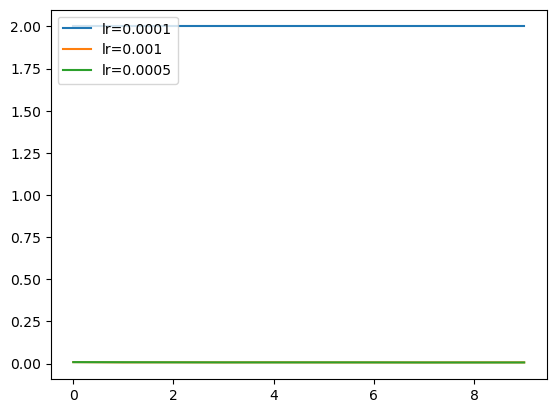

In [41]:
import matplotlib.pyplot as plt

for k, v in history.items():
    plt.plot(v, label = 'lr='+str(k))
    
plt.legend(loc="upper left")




In [42]:
y_pred = model_nn(X_test_t)

In [43]:
y_pred=y_pred.detach().numpy()

In [44]:
#TODO kell ez? 

X_test[X_test.columns]=X_scaler.inverse_transform(X_test_t)
y_test[y_test.columns] =y_scaler.inverse_transform(y_test_t)

In [45]:
y_pred=y_scaler.inverse_transform(y_pred)


In [46]:
eval_df_nn=evaluate_model(X_test, y_test, y_pred)

In [47]:
eval_df_nn.head()

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
420350,2.0,-0.066665,-0.154220,0.220885,1.933335,1.845780,4.528710,131.335851,79.276571,4.633632
56121,1.0,0.300001,0.304821,0.604822,1.300001,1.304821,0.370796,1.606777,1.593972,0.370109
1006891,3.0,-0.450001,-0.618716,1.068717,2.549999,2.381284,6.616280,37.492188,31.573407,6.842645
702620,1.0,-0.733334,-0.611990,1.345325,0.266666,0.388010,45.504035,16.546852,18.039322,37.069888
257760,2.0,0.133333,0.030993,0.164326,2.133333,2.030993,4.797175,76.755157,124.557191,4.915068


In [49]:
eval_df_nn[['KESES (m)','AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,KESES (m),AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235047.000000,235047.000000,2.350470e+05,2.350470e+05,235047.000000,235047.000000
mean,-0.118223,0.833379,4.355844e+04,8.339329e+05,86.127597,17.720385
std,0.817938,0.909186,4.991783e+06,7.749916e+06,73.921653,24.323913
min,-18.216666,0.000008,7.179457e-05,8.646528e-04,0.000865,0.000072
25%,-0.450001,0.274076,3.473340e+00,2.094914e+01,21.907279,3.478256
50%,-0.133334,0.601844,8.647686e+00,4.938599e+01,57.295376,8.678112
75%,0.199999,1.017020,2.148317e+01,1.184589e+02,167.373965,21.485894
max,30.666664,29.780604,1.044097e+09,3.923823e+08,200.000000,200.000000


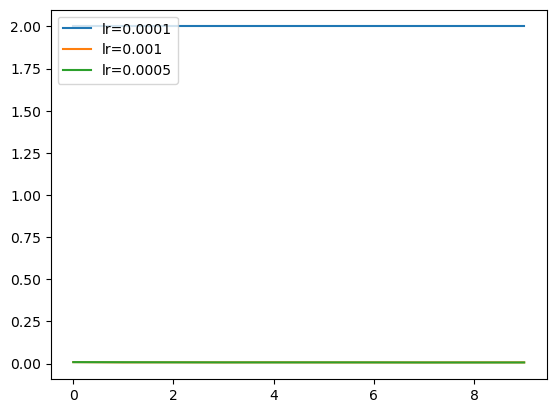

In [50]:
save_NN(model_nn,X_scaler,y_scaler,history,'Base')

In [51]:
del model_nn

# Kisebb adaton:

most rendelkezésre álló adat:
- utastájékoztatásból terv- és tényídők
- időjárás

Azaz dobjuk a lassújel és vágányzár adatokat


In [52]:
raw_data.columns

Index(['TERV_IDOTARTAM (m)', 'KESES (m)', 'ELOZO_SZAKASZ_TERV_IDOTARTAM (m)',
       'ELOZO_SZAKASZ_KESES (m)', 'ELOZO_SZAKASZ_RELATIV_KESES',
       'CSATL_MAX_KESES (m)', 'MENETREND_IDO (m)', 'tx', 't', 'tn', 'r',
       'LINE', 'Érintett objektum típusa', 'Lassúmenet típusa',
       'Lassúmenet hossza', 'Lassúmenet mértéke (km/h)',
       'Lassúmenet mértéke motorvonatra (km/h)', 'Fels.vez. kikapcsolása', 'I',
       'E', 'ÁI', 'ÁE', 'Kizárás (1=VZ,2=LJ)',
       'Kiutalt menetvonalak zavartatása nélkül', 'Státus',
       'ELOZO_VONAT_KESES (m)', 'ELOZO_VONAT_RELATIV_KESES',
       'VONAL_STATUSZ_VALTOZOTT'],
      dtype='object')

In [56]:
attrs_to_use=['MENETREND_IDO','ELOZO_KESES','KESES','tx','t','tn','r','TERV_IDOTARTAM (m)','ELOZO VONAT KESES','ELOZO VONAT RELATIV KESES']
attrs_to_use=['MENETREND_IDO (m)','ELOZO_SZAKASZ_KESES (m)','KESES (m)','tx','t','tn','r','TERV_IDOTARTAM (m)']


In [57]:
raw_data_small=raw_data[attrs_to_use]


In [58]:
def train_and_evaluate_DRT(data):
    history=None
    X_scaler=None
    y_scaler=None
    X_train, X_test, y_train, y_test,_,_ = split_train_test(data)
    model, predictions = train_DRT(X_train,X_test, y_train)
    eval_df = evaluate_model(X_test, y_test, predictions)
    return model,eval_df,X_scaler,y_scaler,history





In [59]:
raw_data_small.head()

,MENETREND_IDO (m),ELOZO_SZAKASZ_KESES (m),KESES (m),tx,t,tn,r,TERV_IDOTARTAM (m)
0,25,0.000000,0.516667,11.7,9.2,6.0,0.0,0.0
1,29,0.516667,0.650000,11.7,9.2,6.0,0.0,4.0
2,30,0.650000,-0.500000,11.7,9.2,6.0,0.0,1.0
3,35,-0.500000,-0.733333,11.7,9.2,6.0,0.0,5.0
4,36,-0.733333,0.250000,11.7,9.2,6.0,0.0,1.0


In [60]:
model_s,eval_df_s,_,_,_=train_and_evaluate_DRT(raw_data_small)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'max_depth': None}


In [61]:
eval_df_s[['AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235047.000000,2.350400e+05,2.337130e+05,233713.000000,235040.000000
mean,0.931015,inf,inf,75.900776,15.694045
std,1.062221,NaN,NaN,75.086327,23.386315
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.285417,2.213434e+00,1.153846e+01,11.764706,2.208650
50%,0.663889,6.896552e+00,4.047619e+01,43.101154,6.880681
75%,1.128571,1.911235e+01,1.107143e+02,141.637011,19.108280
max,33.666667,inf,inf,200.000000,200.000000


In [62]:
save_sklearn_model(model_s,'RT','Small')


In [63]:
del model_s

In [64]:
raw_data_small=raw_data[attrs_to_use]
def train_and_evaluate_NN(data, epoch=20, lr=0.0001):
    X_train, X_test, y_train, y_test,X_scaler,y_scaler = split_train_test(data,True)
    X_train_t, X_test_t, y_train_t, y_test_t = get_data_tensors(X_train, X_test, y_train, y_test)
    input_size=X_train.shape[1]
    model = get_NN_model(input_size)
    #optimizer, loss_fn = get_optimizer(model, lr)
    history, best_mse, best_weights, model=train_NN(X_train_t, X_test_t, y_train_t, y_test_t, model, None, None, epoch)
    y_pred = model(X_test_t)
    y_pred=y_pred.detach().numpy()
    X_test[X_test.columns]=X_scaler.inverse_transform(X_test_t)
    y_test[y_test.columns] =y_scaler.inverse_transform(y_test_t)
    y_pred=y_scaler.inverse_transform(y_pred)
    eval_df_nn = evaluate_model(X_test, y_test, y_pred)
    return model,eval_df_nn,X_scaler,y_scaler,history


In [65]:
model_nn_s,eval_df_nn_s,X_scaler_s,y_scaler, history_s=train_and_evaluate_NN(raw_data_small,20)


    

C:\Users\ELTE\AppData\Local\Temp\ipykernel_14868\4010718233.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_y[pd_y.columns] = y_scaler.fit_transform(pd_y[pd_y.columns])


lr=0.0001m, loss:smape
resetting Linear
resetting Linear
resetting Linear
resetting Linear
Loss SMAPE
Epoch: 0 smape :  0.009997818619012833 Best smape inf
Epoch: 1 smape :  0.009886006824672222 Best smape 0.009997818619012833
Epoch: 2 smape :  0.009853582829236984 Best smape 0.009886006824672222
Epoch: 3 smape :  0.009820270352065563 Best smape 0.009853582829236984
Epoch: 4 smape :  0.00979634653776884 Best smape 0.009820270352065563
Epoch: 5 smape :  0.009850588627159595 Best smape 0.00979634653776884
Epoch: 6 smape :  0.009850867092609406 Best smape 0.00979634653776884
Epoch: 7 smape :  0.009832494892179966 Best smape 0.00979634653776884
Epoch: 8 smape :  0.009842051193118095 Best smape 0.00979634653776884
Epoch: 9 smape :  0.009786645881831646 Best smape 0.00979634653776884
Epoch: 10 smape :  0.009762217290699482 Best smape 0.009786645881831646
Epoch: 11 smape :  0.00975816324353218 Best smape 0.009762217290699482
Epoch: 12 smape :  0.009735634550452232 Best smape 0.009758163243532

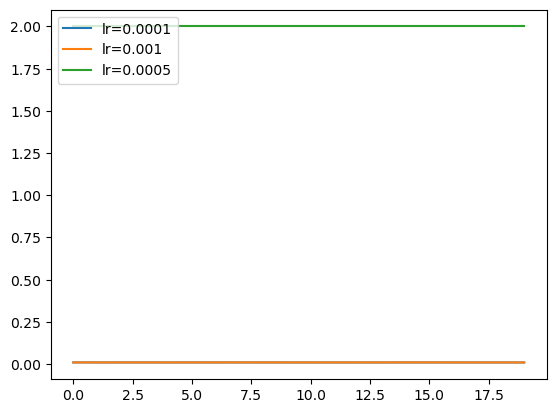

In [66]:
save_NN(model_nn_s,X_scaler_s,y_scaler,history_s,'Small')



In [67]:
eval_df_nn_s.head()

,TERV_IDOTARTAM (m),KESES (m),predictions,AE,Tény,Pred,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
420350,2.0,-0.066665,0.007043,0.059622,1.933335,2.007043,3.812492,110.564997,200.000000,3.741176
56121,1.0,0.300001,-0.023992,0.276009,1.300001,0.976008,24.922498,107.997273,200.000000,28.470246
1006891,3.0,-0.450001,-0.050160,0.500161,2.549999,2.949840,15.680017,88.853269,159.884627,14.540074
702620,1.0,-0.733334,-0.291240,1.024574,0.266666,0.708760,165.785844,60.285507,86.298144,90.646397
257760,2.0,0.133333,-0.022282,0.111051,2.133333,1.977718,7.294424,116.711320,200.000000,7.570538


In [69]:
eval_df_nn_s[['AE',"MAPE (KESES)","MAPE (MENETIDO)","SMAPE (KESES)","SMAPE (MENETIDO)"]].describe()

,AE,MAPE (KESES),MAPE (MENETIDO),SMAPE (KESES),SMAPE (MENETIDO)
count,235047.000000,2.350470e+05,2.350470e+05,235047.000000,2.350470e+05
mean,0.561265,6.431514e+04,3.125361e+05,154.145861,2.591639e+01
std,0.655161,7.041171e+06,2.864149e+06,58.830782,2.585564e+01
min,0.000005,8.466580e-08,3.725387e-06,0.000004,8.466580e-08
25%,0.169664,6.767650e+00,7.762904e+01,118.585237,6.806573e+00
50%,0.409866,1.808238e+01,9.714810e+01,183.624072,1.821256e+01
75%,0.696177,4.089311e+01,1.161512e+02,200.000000,3.769065e+01
max,30.666912,1.071826e+09,3.741351e+08,200.000000,2.000000e+02


In [ ]:
del model_nn_s

In [ ]:
del raw_data_small
del raw_data
    

# loading the models and validate them

In [ ]:
import pandas as pd
from config import data_root

In [ ]:
validation_data=pd.read_csv(data_root+'validation_data.csv')
y=validation_data['KESES']
X=validation_data.drop(columns=['KESES','RELATIV_KESES'])
X_additional=X[['VONATSZAM','KOZLEKEDESI_NAP']]
X.drop(columns=['VONATSZAM','KOZLEKEDESI_NAP'], inplace=True)
if 'KESES' in attrs_to_use:
    attrs_to_use.remove('KESES')
X_small=X[attrs_to_use]





In [ ]:
#model/data_desc/model_desc
base_RT = load_sk_by_desc('RT','base','Base')['model']
small_RT = load_sk_by_desc('RT','base','Small')['model']


In [ ]:
base_RT.feature_names_in_

In [ ]:
small_RT.feature_names_in_


In [ ]:
y_pred_dt_base=small_RT.predict(X_small)
#small_RT_res=evaluate_model(X_small,y,y_pred)



In [ ]:
y_pred_dt_small=base_RT.predict(X)
#base_RT_res=evaluate_model(X,y,y_pred)

In [ ]:
del small_RT
del base_RT

In [ ]:
validation_data.head()

In [ ]:
import torch
base_X_scaler=load_sk_by_desc('X_scaler','base','base')['model']
base_y_scaler=load_sk_by_desc('y_scaler','base','base')['model']

X_t = torch.tensor(base_X_scaler.transform(X), dtype=torch.float32)
nn_base=load_NN('./model/NN/base/base/')['model']
y_pred_nn_base=base_y_scaler.inverse_transform(nn_base(X_t).detach().numpy())
del base_X_scaler
del base_y_scaler
del nn_base
del X_t


In [ ]:
attrs_to_use

In [ ]:


small_X_scaler=load_sk_by_desc('X_scaler','base','Small')['model']
small_y_scaler=load_sk_by_desc('y_scaler','base','Small')['model']

X_t = torch.tensor(small_X_scaler.transform(X_small), dtype=torch.float32)
nn_small=load_NN('./model/NN/Small/base/')['model']
y_pred_nn_small=small_y_scaler.inverse_transform(nn_small(X_t).detach().numpy())
del small_X_scaler
del small_y_scaler
del nn_small
del X_t



In [ ]:
#del y
del X
del X_small

In [ ]:
names = ['P-NN-small','P-DT','P-DT-small','KESES']
#preds=[y_pred_nn_base.squeeze(),y_pred_nn_small.squeeze(),y_pred_dt_base,y_pred_dt_small,y]
preds=[y_pred_nn_small.squeeze(),y_pred_dt_base,y_pred_dt_small,y]
cols_to_add=pd.DataFrame(dict(zip(names,preds)))

In [ ]:
type(y_pred_dt_small[:5])

In [ ]:
y_pred_dt_small.reshape(1,).shape

In [ ]:
type(y_pred_nn_base[:5])

In [ ]:
y_pred_nn_base.squeeze().shape

In [ ]:
df_to_validate_orig=pd.read_pickle(data_root+'validation_orig.pkl')
df_to_validate_orig.drop(columns=['KESES'], inplace=True)

In [ ]:
df_to_validate_orig.reset_index(drop=True, inplace=True)
cols_to_add.reset_index(drop=True, inplace=True)

In [ ]:
eval_df=pd.concat([df_to_validate_orig,cols_to_add], axis=1)

In [ ]:
eval_df.head()

In [ ]:
eval_df.to_pickle(data_root+'validation_res.pkl')

In [ ]:
preds_=pd.read_pickle(data_root+'validation_res.pkl')


In [ ]:
preds_

In [ ]:
preds.columns

In [ ]:
eval_df=preds_.copy()

In [ ]:
eval_df['KOZLEKEDESI_NAP']=pd.to_datetime(eval_df['ELOZO_ESEMENY_IDO']).dt.date
eval_df['TENY_IDOTARTAM']=eval_df['TERV_IDOTARTAM (m)']+eval_df['KESES']
if 'KESES' in names:
    names.remove('KESES')
eval_df=eval_df[['VONATSZAM','KOZLEKEDESI_NAP','KESES','OSSZ_KESES','TENY_IDOTARTAM','TERV_IDOTARTAM (m)']+names]
metrics=[]
aes=[]
ape_stat_s=[]
apes_delay_s=[]
for n in names:
    print(n)
    eval_df['JOSOLT_IDOTARTAM ' + n]=eval_df['TERV_IDOTARTAM (m)']+eval_df[n]
    
    # menetido alapján
    eval_df[f'{n} AE (MENETIDO)']=abs(eval_df['TENY_IDOTARTAM']-eval_df['JOSOLT_IDOTARTAM ' + n])
    metrics.append(f'{n} AE (MENETIDO)')
    aes.append(f'{n} AE (MENETIDO)')

    eval_df[f'{n} APE (MENETIDO)']=abs(eval_df['TENY_IDOTARTAM']-eval_df['JOSOLT_IDOTARTAM ' + n])/eval_df['TENY_IDOTARTAM'] *100
    metrics.append(f'{n} APE (MENETIDO)')
    ape_stat_s.append(f'{n} APE (MENETIDO)')

    eval_df[f'{n} APE (KESES)']=abs(eval_df['KESES']-eval_df[n])/eval_df['KESES'] *100
    metrics.append(f'{n} APE (KESES)')
    apes_delay_s.append(f'{n} APE (KESES)')



In [ ]:
eval_df

In [ ]:
ae_res=eval_df[aes].describe()

In [ ]:
print(ae_res.to_latex())

In [ ]:
eval_df[metrics].describe()

In [ ]:
eval_df_restrcited=eval_df[(eval_df['KESES']>5) & (eval_df['TERV_IDOTARTAM (m)']>10)]

In [ ]:
eval_df_restrcited.head()

In [ ]:
ape_stat_res=eval_df_restrcited[ape_stat_s].describe()

In [ ]:
print(ape_stat_res.to_latex())

In [ ]:
apes_delay_res=eval_df_restrcited[apes_delay_s].describe()
print(apes_delay_res.to_latex())

# Spearman

In [ ]:
from config import data_root
import pandas as pd

In [ ]:
s_validation_data=pd.read_pickle(data_root+'validation_orig.pkl')



In [ ]:
s_validation_data[]

In [ ]:
import datetime    
def previous_data_and_route(date_and_time:datetime.datetime, train_no=None):
    #todo live
    if train_no:
        print(train_no)
        schedule=s_validation_data[(s_validation_data['KOZLEKEDESI_NAP']==pd.to_datetime(date_and_time.date())) & (s_validation_data['VONATSZAM'].isin(train_no))]
    else:
        schedule=s_validation_data[s_validation_data['KOZLEKEDESI_NAP']==date_and_time.date() ]
    #ELOZO_ESEMENY_IDO= tervezett idő
    schedule['TENY_IDO']=pd.to_datetime(date_and_time.date()) + pd.to_timedelta(schedule['MENETREND_IDO'].astype(str))+schedule['OSSZ_KESES']    
    schedule['ELOZO_TENY_IDO']=schedule['ELOZO_ESEMENY_IDO']+schedule['OSSZ_KESES']-schedule['KESES']
    actual_record=schedule[(schedule['ELOZO_TENY_IDO']<=date_and_time) & (schedule['TENY_IDO']>date_and_time)]
    
    schedule_past=schedule[schedule['ELOZO_TENY_IDO']<=date_and_time]
    schedule_future=schedule[schedule['ELOZO_TENY_IDO']>date_and_time]
    return schedule,schedule_past,schedule_future,actual_record

    

def predict(date:datetime.date,time:datetime.time=None,number:int=None):
    dt = datetime.datetime.combine(date, time)
    schedule,schedule_past,schedule_future,actual_record=previous_data_and_route(dt,number)
    return schedule,schedule_past,schedule_future,actual_record
    
    
train_no=[2019]

date=datetime.date(2023,7,3)
time=datetime.time(4,15)
schedule,schedule_past,schedule_future,actual_record=predict(date,time,train_no)

    

In [ ]:
 
date_and_time=datetime.datetime.combine(date, time)
schedule=s_validation_data[(s_validation_data['KOZLEKEDESI_NAP']== pd.to_datetime(date_and_time.date())) ]
#schedule['TENY_IDO']=pd.to_datetime(date_and_time.date()) + pd.to_timedelta(schedule['MENETREND_IDO'].astype(str))+schedule['OSSZ_KESES']   
#res=schedule.head().apply(lambda r : datetime.datetime.combine(r['KOZLEKEDESI_NAP'],r['MENETREND_IDO']),1)
#res

In [ ]:
schedule

In [ ]:
schedule[schedule['MENETREND_IDO'].map(type) == float]

In [ ]:
schedule

In [ ]:
train_no=[2019]

date=datetime.date(2023,7,3)
time=datetime.time(4,15)
date_and_time = datetime.datetime.combine(date, time)

schedule=s_validation_data[(s_validation_data['KOZLEKEDESI_NAP']==date_and_time.date()) & (s_validation_data['VONATSZAM'].isin(train_no))]


In [ ]:
schedule

In [ ]:
actual_record=schedule[(schedule['ELOZO_TENY_IDO']<=date_and_time) & (schedule['MENETREND_IDO']+schedule['OSSZ_KESES'].map(pd.Timedelta.to_pytimedelta)>date_and_time)]

In [ ]:
schedule_past

In [ ]:
s_validation_data[(s_validation_data['KOZLEKEDESI_NAP']==date_and_time.date())]

In [ ]:
pd.to_datetime(s_validation_data['KOZLEKEDESI_NAP']).head()

In [ ]:
date_and_time.date()

In [ ]:
s_validation_data.head()

In [ ]:
print('hello')